In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,10)
legend_fontsize = 16

# Деревья принятия решений

## Сгенерируем данные

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'ls', 'transparent'
  s)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color'
  s)


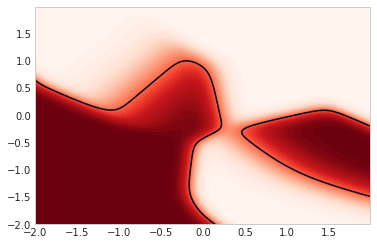

In [34]:

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

centers_1 = np.random.multivariate_normal([-1,-1], 1.5*np.identity(2), size=10)
centers_2 = np.random.multivariate_normal([1,1], 1.5*np.identity(2), size=10)

def mn(x, c, mat):
	return sp.stats.multivariate_normal.pdf(x, mean=c, cov=mat)

def sample_point(centers, cov=.1 * np.identity(2)):
	i = np.random.randint(len(centers))
	return np.random.multivariate_normal(centers[i], cov)

def my_density(pos, centers):
	return np.sum([ mn(pos, c, .1 * np.identity(2)) for c in centers ], axis=0) / float(len(centers))

def my_density_ratio(pos, centers_1, centers_2):
	return my_density(pos, centers_1) / (my_density(pos, centers_1) + my_density(pos, centers_2))

z_1 = my_density(pos, centers_1)
z_2 = my_density(pos, centers_2)
z = my_density_ratio(pos, centers_1, centers_2)

num_levels = 50
plt.contourf(x, y, z, num_levels, cmap='Reds', ls=None, transparent=True)
plt.contour(x, y, z, levels=[0.5], color='black')
plt.show()

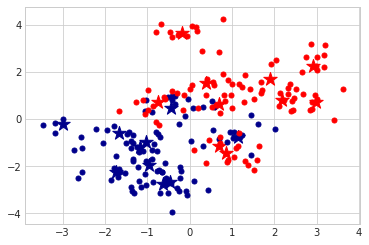

In [35]:
points_1 = np.array([ sample_point(centers_1, cov=.2 * np.identity(2)) for _ in range(100) ])
points_2 = np.array([ sample_point(centers_2, cov=.2 * np.identity(2)) for _ in range(100) ])

def plot_twopoints(ax, d1, d2, sizes=[15,25], markers=[ 'o', '*' ], colors=['0.3', '0.3']):
	ax.scatter(d1[:,0], d1[:,1], s=sizes[0], marker=markers[0], color=colors[0])
	ax.scatter(d2[:,0], d2[:,1], s=sizes[1], marker=markers[1], color=colors[1])

fig, ax = plt.subplots()
plot_twopoints(ax, centers_1, centers_2, sizes=[200,200], markers=['*', '*'], colors=['darkblue', 'r'])
plot_twopoints(ax, points_1, points_2, sizes=[25,25], markers=['o', 'o'], colors=['darkblue', 'r'])
plt.show()

## Логистическая регрессия

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'ls'
  s)


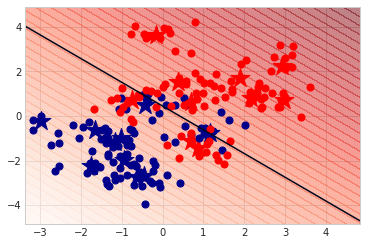

[[1.05841545 0.99321577]] [0.05805798]


In [36]:
x_and_y = [ (p, 0) for p in points_1 ] + [ (p,1) for p in points_2 ]
np.random.shuffle(x_and_y)

data_X = np.array([x[0] for x in x_and_y])
data_y = np.array([x[1] for x in x_and_y])
x_min, x_max = min(data_X[:,0]), max(data_X[:,0])
y_min, y_max = min(data_X[:,1]), max(data_X[:,1])

from sklearn import linear_model
import sklearn

m = sklearn.linear_model.LogisticRegression()
m.fit(data_X, data_y)

def plot_model_results(m, c1=centers_1, c2=centers_2, p1=points_1, p2=points_2):
    xdata = np.array([ x for x in points_1 + points_2 ])
    x_min, x_max = min(xdata[:,0]), max(xdata[:,0])
    y_min, y_max = min(xdata[:,1]), max(xdata[:,1])
    x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pos_lin = pos.reshape(pos.shape[0] * pos.shape[1], 2)
    pred_lin = m.decision_function(pos_lin)
    pred = pred_lin.reshape(pos.shape[0], pos.shape[1])

    fig, ax = plt.subplots()
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.contourf(x, y, pred, num_levels, cmap='Reds', alpha=0.5, ls=None)
    ax.contour(x, y, pred, levels=[0.5])
#     ax.plot(np.arange(x_min, x_max, .01), (-m.intercept_ - m.coef_[0][0]*np.arange(x_min, x_max, .01)) / m.coef_[0][1], color='black')
    plot_twopoints(ax, centers_1, centers_2, sizes=[400,400], markers=['*', '*'], colors=['darkblue', 'r'])
    plot_twopoints(ax, points_1, points_2, sizes=[50,50], markers=['o', 'o'], colors=['darkblue', 'r'])
    plt.show()
    
plot_model_results(m)
print(m.coef_, m.intercept_)

## Дерево принятия решений

Сначала создаём и обучаем дерево; это, как всегда, две строчки. :)

In [37]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=100)
clf = clf.fit(data_X, data_y)

Рисуем дерево -- к сожалению, по умолчанию это делается через graphviz. То есть сначала создаём graphviz-данные для графика, а потом используем специальный пакет pydotplus, чтобы не сохранять в файл, а превратить в картинку прямо здесь.

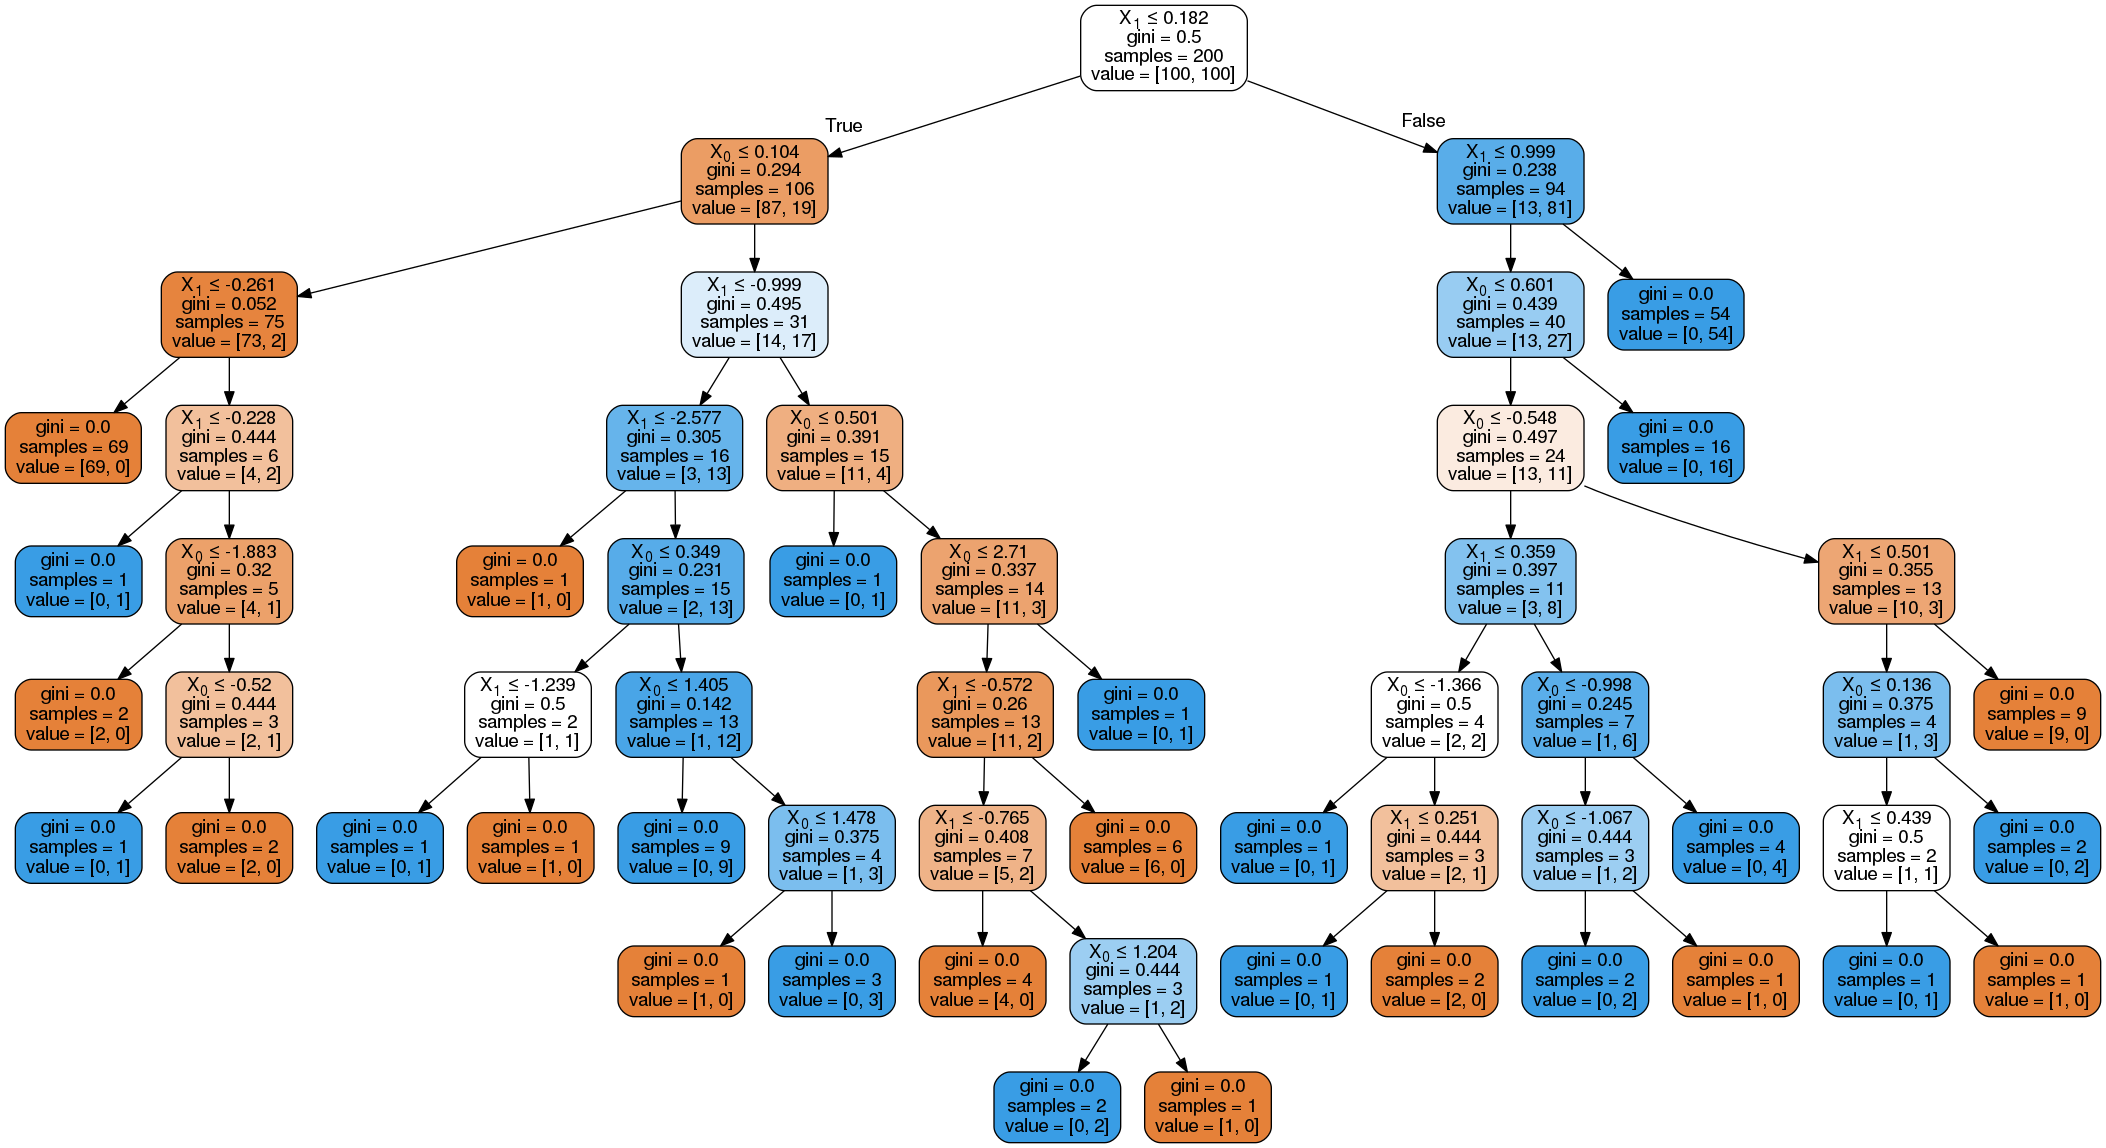

In [38]:
import pydotplus
from IPython.display import Image, display

def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                             filled=True, rounded=True,  
                             special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)  
    display(Image(graph.create_png()))

plot_tree(clf)

Функция для рисования результата применения дерева. На самом деле для любого классификатора будет работать -- она
просто предсказывает результат в каждой точке и закрашивает.

In [39]:
def plot_classifier(clf, data_X, plot_step=0.01, use_xgboost=False):
    x_min, x_max = data_X[:, 0].min() - 1, data_X[:, 0].max() + 1
    y_min, y_max = data_X[:, 1].min() - 1, data_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    data_to_predict = np.c_[xx.ravel(), yy.ravel()]
    if use_xgboost:
        data_to_predict = xgb.DMatrix(data_to_predict)
    Z = clf.predict(data_to_predict)
    if use_xgboost:
        Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.5)

Теперь можно всё нарисовать. Получается как-то слишком детально, явный оверфиттинг.

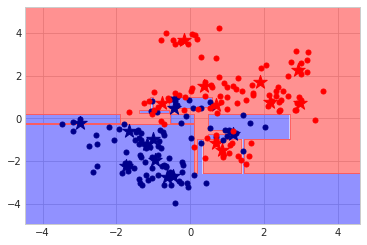

In [40]:
def plot_classifier_with_points(clf, use_xgboost=False):
    fig, ax = plt.subplots()
    plot_classifier(clf, data_X, use_xgboost=use_xgboost)
    plot_twopoints(ax, centers_1, centers_2, sizes=[200,200], markers=['*', '*'], colors=['darkblue', 'r'])
    plot_twopoints(ax, points_1, points_2, sizes=[25,25], markers=['o', 'o'], colors=['darkblue', 'r'])
    plt.axis("tight")
    plt.show()

clf = tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(data_X, data_y)
plot_classifier_with_points(clf)

Давайте попробуем посмотреть, как выглядят деревья разной глубины.

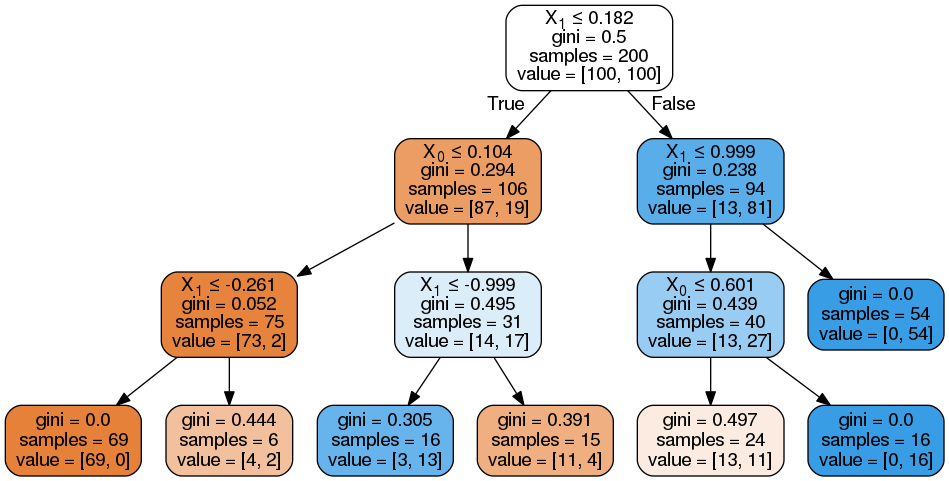

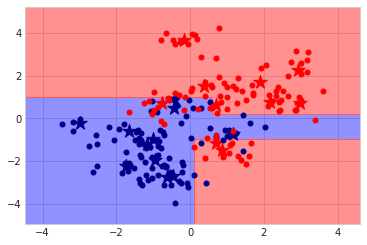

In [41]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(data_X, data_y)
plot_tree(clf)
plot_classifier_with_points(clf)

## Бустинг

Начнём с AdaBoost на "пнях принятия решений", то есть деревьях глубины 1. Обратите внимание, что результат довольно выразительный.

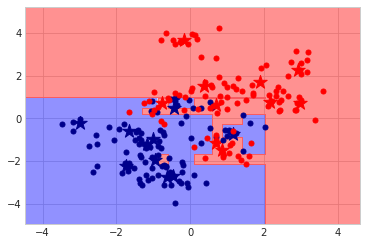

In [44]:
import sklearn.ensemble
clf = sklearn.ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1), n_estimators=20)
clf.fit(data_X, data_y)
plot_classifier_with_points(clf)

In [47]:
clf.feature_importances_

array([0.5, 0.5])

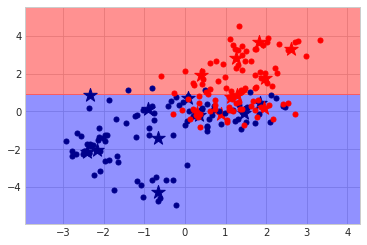

In [21]:
plot_classifier_with_points(x)

Если углубить деревья, то оверфиттинг не заставит себя ждать.

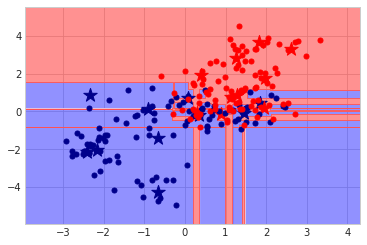

In [28]:
clf = sklearn.ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3), n_estimators=10)
clf.fit(data_X, data_y)
plot_classifier_with_points(clf)

Теперь попробуем градиентный бустинг.

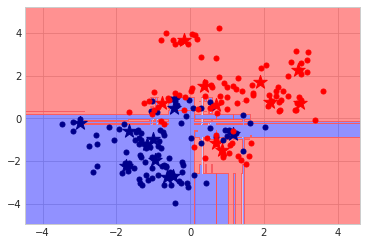

In [48]:
clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100)
clf.fit(data_X, data_y)
plot_classifier_with_points(clf)

In [50]:
clf.feature_importances_

array([0.48372282, 0.51627718])

И, наконец, продемонстрируем полноценный XGBoost.

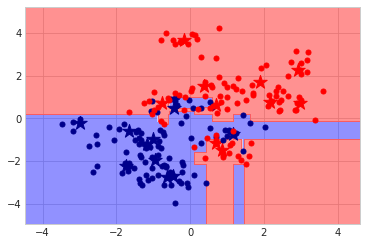

In [43]:
import xgboost as xgb
dtrain = xgb.DMatrix(data_X, label=data_y)
clf = xgb.train({'max_depth':3, 'eta':1, 'silent':0, 'objective':'binary:logistic' }, dtrain, 10)
plot_classifier_with_points(clf, use_xgboost=True)